In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull, cKDTree
import numpy as np
from matplotlib.lines import Line2D
import math
import scipy.sparse as sparse
import seaborn as sns
from statistics import mean
from pandas.plotting import autocorrelation_plot
from math import isclose

This notebook does the clustering based on morphological parameters and plots them for each parameter in box plots.

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Define a function to read and append data
def read_and_append_data(image_name):
    df = pd.read_csv(f"/content/drive/My Drive/Rev_II/alldata/{image_name}_morphNmotility.txt")
    df['imageName'] = image_name

    speed_data = pd.read_csv(f"/content/drive/My Drive/Rev_II/alldata/{image_name}_Speed_allCells.txt")
    df['Speed_allCells'] = speed_data.values.tolist()

    per_data = pd.read_csv(f"/content/drive/My Drive/Rev_II/alldata/{image_name}_Persistence_cellWise.txt")
    df['Per_allCells'] = per_data.values.tolist()

    cellarea_data = pd.read_csv(f"/content/drive/My Drive/Rev_II/alldata/{image_name}_CellAreaAll.txt")
    df['CellAreaAll'] = cellarea_data.values.tolist()

    dist_data = pd.read_csv(f"/content/drive/My Drive/Rev_II/alldata/{image_name}_Dist_travelled.txt")
    df['Dist_travelled'] = dist_data.values.tolist()

    cx_data = pd.read_csv(f"/content/drive/My Drive/Rev_II/alldata/{image_name}_CellCx.txt")
    df['CellCx'] = cx_data.values.tolist()

    cy_data = pd.read_csv(f"/content/drive/My Drive/Rev_II/alldata/{image_name}_CellCy.txt")
    df['CellCy'] = cy_data.values.tolist()

    return df

# Define a list of image names
image_names = ['M0_N', 'M1_N', 'M2_N', 'M0_16', 'M1_16', 'M2_16', 'M0VAL_N', 'M1VAL_N', 'M2VAL_N','M1_3N', 'M1_4N', 'M2_3N', 'M2_4N', 'M2_5N', 'M2_6N']

# Create an empty dataframe to store all data
df = pd.DataFrame()

# Loop through the image names and append data to a single dataframe
for image_name in image_names:
    all_data = read_and_append_data(image_name)
    df = pd.concat([df, all_data], ignore_index=True)

df['cmp'] = np.where(df['cmp'] > 1.0, 1.0, df['cmp']).astype(float)

# Define a dictionary to map the values to their replacements
image_name_mapping = {
    'M0_N': 'M0', 'M1_N': 'M1','M2_N': 'M2', 'M0_16': 'M0', 'M1_16': 'M1','M2_16': 'M2',
    'M0VAL_N': 'M0', 'M1VAL_N': 'M1','M2VAL_N': 'M2',
    'M1_3N': 'M1', 'M1_4N': 'M1',
    'M2_3N': 'M2', 'M2_4N': 'M2', 'M2_5N': 'M2', 'M2_6N': 'M2'
}

# Replace values in the 'imageName' column
df['imageName'] = df['imageName'].replace(image_name_mapping)

# Consider the cells which exist for 1 hour in the time-series
df['consider'] = df['CellAreaAll'].apply(lambda x: 'True' if np.count_nonzero(~np.isnan(x)) >= 11 else 'False')

# Find the maximum frame length of the Speed column -- This is to know the Validation data which is 4 hours
max_length = df['Speed_allCells'].apply(len).max()
df['val_data'] = df['Speed_allCells'].apply(len) == max_length

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-4-ab88f83fe962>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  columns['Cluster'] = y
<ipython-input-4-ab88f83fe962>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  columns['cen_x'] = columns.Cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3]})
<ipyth

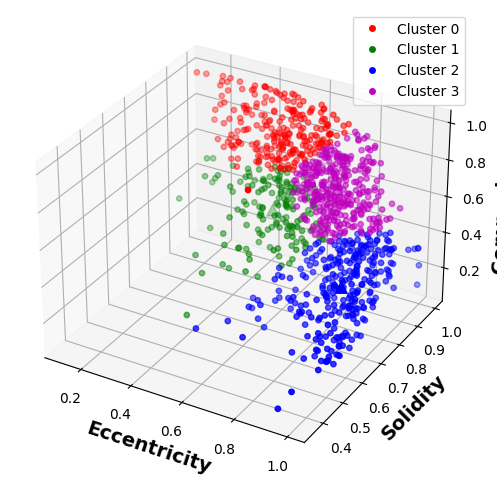

In [4]:
columns = df[df['consider'] == 'True']

##k means using morphological params
kmeans = KMeans(n_clusters=4,random_state=133)
y = kmeans.fit_predict(columns[['ecc','sol','cmp']])
columns['Cluster'] = y

## get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids]
cen_y = [i[1] for i in centroids]
cen_z = [i[2] for i in centroids]


## add to columns df
columns['cen_x'] = columns.Cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3]})
columns['cen_y'] = columns.Cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2], 3:cen_y[3]})
columns['cen_z'] = columns.Cluster.map({0:cen_z[0], 1:cen_z[1], 2:cen_z[2], 3:cen_z[3]})


colors = ['r', 'g', 'b','m']
columns['color'] = columns.Cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})

## Plot 3D scatter plot
fig = plt.figure(figsize=(26,6))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(columns.ecc, columns.sol, columns.cmp, c = columns.color, s=15)
ax.scatter(cen_x, cen_y, cen_z, marker='^', c=colors, s=70)
# plot lines
for idx, val in columns.iterrows():
    x = [val.ecc, val.cen_x,]
    y = [val.sol, val.cen_y]
    z = [val.cmp, val.cen_z]
    #plt.plot(x, y, z, c=val.color, alpha=0.2)

ax.set_xlabel('Eccentricity',fontweight="bold",fontsize="14")
ax.set_ylabel('Solidity',fontweight="bold",fontsize="14")
ax.set_zlabel('Compactness',fontweight="bold",fontsize="14")

#lcolors = ['g', 'b', 'r','m']
# legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i),
                   markerfacecolor=mcolor, markersize=6) for i, mcolor in enumerate(colors)]

#plt.legend(handles=legend_elements,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(handles=legend_elements ,loc='best')
plt.grid('off')
#plt.title('Morphological params clustering')
plt.show()

<ipython-input-20-5f66955fde20>:25: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(y=feature, x="Cluster", zorder=2, size=2.5, data=columns, palette=colors, alpha=0.8, ax=ax)
<ipython-input-20-5f66955fde20>:25: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(y=feature, x="Cluster", zorder=2, size=2.5, data=columns, palette=colors, alpha=0.8, ax=ax)
<ipython-input-20-5f66955fde20>:25: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(y=feature, x="Cluster", zorder=2, size=2.5, data=columns, palette=colors, alpha=0.8, ax=ax)


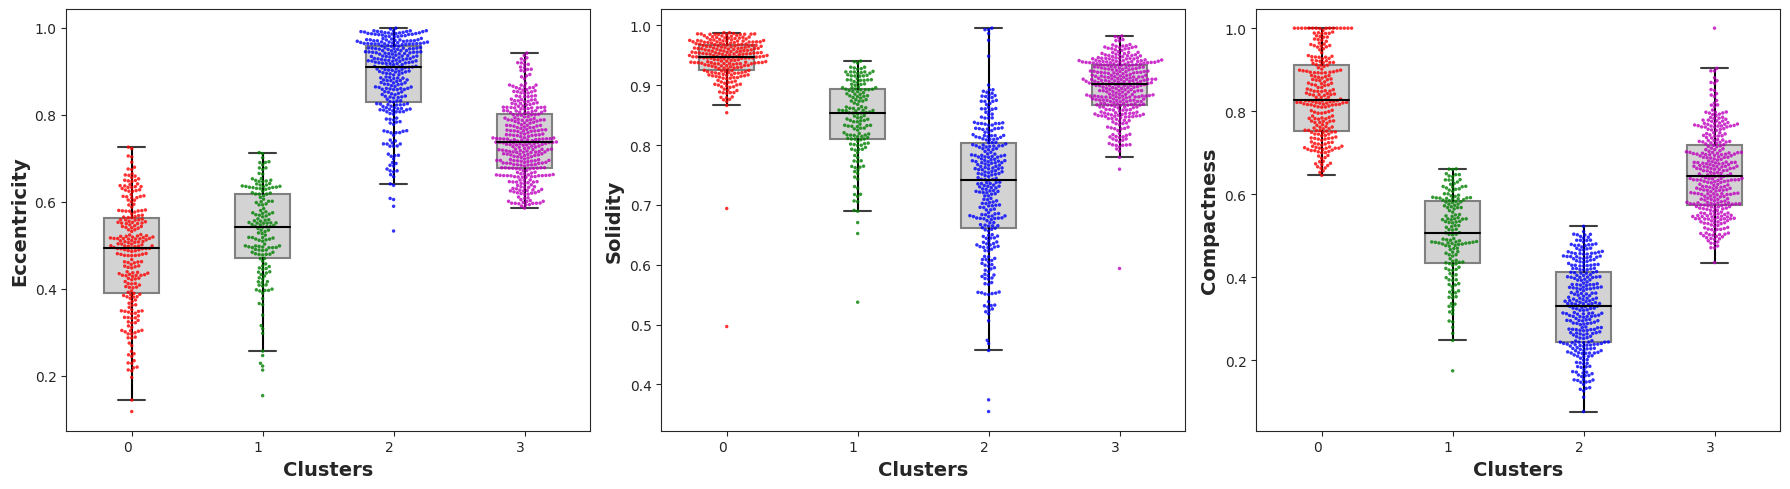

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Create a 1x3 grid of subplots

# Labels for y-axes
y_axis_labels = ["Eccentricity", "Solidity", "Compactness"]

for i, feature in enumerate(["ecc", "sol", "cmp"]):
    ax = axes[i]

    columns['Cluster_str'] = columns['Cluster']
    columns = columns.astype({"Cluster_str": str}, errors='raise')

    clusters = ["0", "1", "2", "3"]

    boxprops = dict(linewidth=1.5, color='gray', facecolor='lightgray')
    whiskerprops = dict(linewidth=1.5, color='black')
    medianprops = dict(linewidth=1.5, color='black')

    bplot = sns.boxplot(y=feature, x="Cluster",
                        data=columns,
                        width=0.42, fliersize=0, ax=ax, boxprops=boxprops, whiskerprops=whiskerprops,
                        medianprops=medianprops)

    bplot.set_xticklabels(clusters, horizontalalignment='right')

    sns.swarmplot(y=feature, x="Cluster", zorder=2, size=2.5, data=columns, palette=colors, alpha=0.8, ax=ax)

    sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
    ax.set_xlabel('Clusters', fontweight="bold", fontsize="14")
    ax.set_ylabel(y_axis_labels[i], fontweight="bold", fontsize="14")

plt.tight_layout()
plt.show()


Silhouette score plot

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

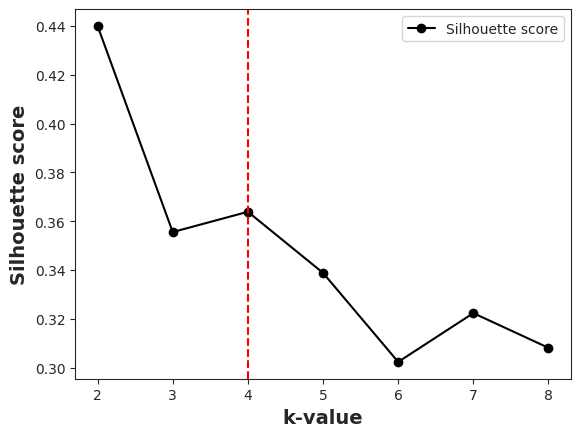

In [23]:
## to find the optimal k-value
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np

sil = []
kmax = 8


all_df = columns[['ecc','sol','cmp']]
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(all_df)
  labels = kmeans.labels_
  sil.append(silhouette_score(all_df, labels, metric = 'euclidean'))


plt.plot(range(2, kmax+1), sil, 'ko-',label="Silhouette score")
plt.xlabel('k-value',fontweight="bold",fontsize="14")
plt.ylabel('Silhouette score',fontweight="bold",fontsize="14")
plt.legend()
plt.axvline(x=4, color="red", linestyle="--")
plt.show()


Silhouette plots

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.44003106581669515
For n_clusters = 3 The average silhouette_score is : 0.35558831303377714


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.3638942056106895


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.33847774547669635


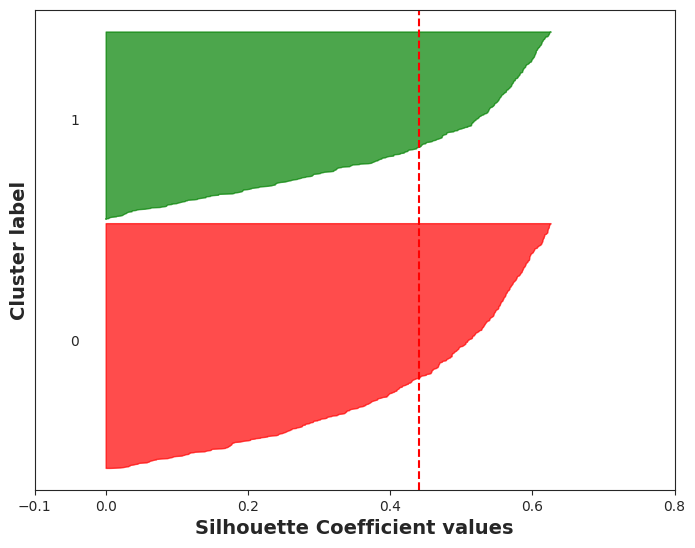

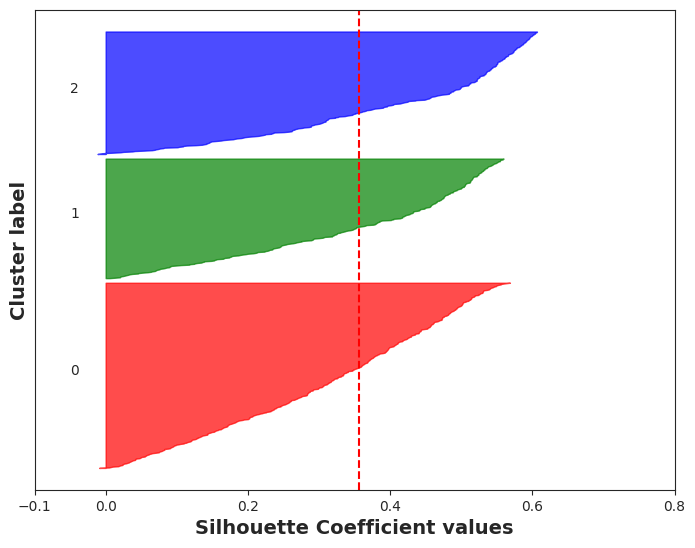

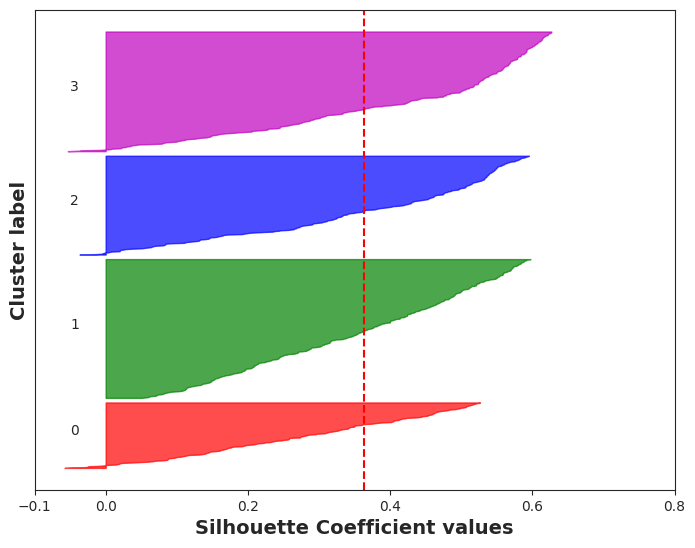

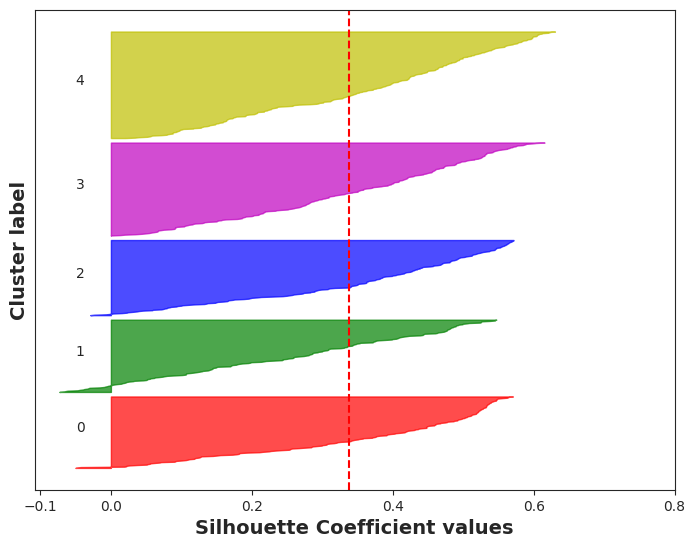

In [25]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples


range_n_clusters = [2,3, 4, 5]
silhouette_avg_n_clusters = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    #fig, ax1 = plt.subplots(1, 2)
    fig  = plt.figure()
    ax1 = fig.add_axes([0, 0, 1, 1])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(all_df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(all_df, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(all_df, cluster_labels)

    y_lower = 10
    c_colors = ['r', 'g', 'b','m','y']
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = c_colors[i]#cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("Silhouette Coefficient values",fontweight="bold",fontsize="14")
    ax1.set_ylabel("Cluster label",fontweight="bold",fontsize="14")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8])
    #ax1.grid('on')

plt.show()